In [252]:
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import make_scorer

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin , ClassifierMixin, RegressorMixin


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [253]:

class KappaEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,kappa = 0):
        self.kappa = kappa

    def kappa_impute(self,x_t,x_i,y_i,kappa):
        distances = np.abs(x_t - x_i)
        weights = 1 / ((1 + distances) ** kappa)
        return np.sum(y_i * weights)/np.sum(weights)

    def encode(self, X):
        for col in self.columns:
            unique_vals = np.unique(X[:,col])
            X_train_col_np = self.train_col_values[col]
            for val in unique_vals:
                self.missing_values[(col, val)] = self.kappa_impute(val,X_train_col_np,self.train_target_values,self.kappa[col])
            for val in set(np.unique(X_train_col_np)) - set(unique_vals):
                self.missing_values[(col, val)] = self.missing_values[(col, val)] = self.kappa_impute(val,X_train_col_np,self.train_target_values,self.kappa[col])
        for (col,val), imputed_value in self.missing_values.items():
            X[X[:,col] == val,col] = imputed_value
        return X

    def fit(self,X,y):
        self.columns = list(range(0,X.shape[1]))
        self.missing_values = {}
        self.train_col_values = {col:X[:,col] for col in self.columns}
        self.train_target_values = y

    def transform(self, X , y = None):
        return self.encode(X.copy())

    def fit_transform(self, X , y):
        self.fit(X, y)
        return self.transform(X)




class KappaClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,kappa = 0):
        self.kappa = kappa

    def fit (self,X,y):
        #add check method
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)

    def predict(self,X):
        #add check fit method
        d = np.linalg.norm(X[:, None] - self.X_train, axis=2)
        weights = 1 / (1 + d ) ** self.kappa
        c = np.sum(self.y_train * weights, axis=1) / np.sum(weights, axis=1)
        c = np.around(c,decimals=0) #uses a threshold of 0.5 we can be more elegant about this
        return c


    def predict_proba(self,X):
        d = np.linalg.norm(X[:, None] - self.X_train, axis=2)
        weights = 1 / (1 + d ) ** self.kappa
        c = np.sum(self.y_train * weights, axis=1) / np.sum(weights, axis=1)
        c = np.vstack((1-c,c)).T
        return c

In [254]:
random_state = 42

In [255]:
#df = pd.read_csv("/kaggle/input/stroke-prediction-by-123-of-ai-dec-2023/stroke_train_set.csv")
df = pd.read_csv("https://drive.google.com/uc?export=download&id=16EwHgKlp8HiyXiS1mQD7FdqQ8H4_iG3B")

#X_test = pd.read_csv("/kaggle/input/stroke-prediction-by-123-of-ai-dec-2023/stroke_test_set_nogt.csv")
X_test = pd.read_csv("https://drive.google.com/uc?export=download&id=14_uk0ApoB9RNMY90ztyqXcn2-b5k-KEr")

df = df.dropna()

BMI_avg = df.loc[:, 'bmi'].mean()
X_test = X_test.fillna(value = BMI_avg)

df = df.drop(df[df['gender'] == 'Other'].index)

df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['work_type'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1})
df['smoking_status'] = df['smoking_status'].map({'never smoked': 0, 'smokes': 1, 'formerly smoked': 2, 'Unknown': 3})

X_test['gender'] = X_test['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
X_test['ever_married'] = X_test['ever_married'].map({'Yes': 1, 'No': 0})
X_test['work_type'] = X_test['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
X_test['Residence_type'] = X_test['Residence_type'].map({'Urban': 0, 'Rural': 1})
X_test['smoking_status'] = X_test['smoking_status'].map({'never smoked': 0, 'smokes': 1, 'formerly smoked': 2, 'Unknown': 3})


In [256]:
def remove_outliers(df, column, lower_bound=None, upper_bound=None):
    """
    Remove outliers from a given feature in a dataframe.

    Parameters:
        df (DataFrame): The input dataframe.
        column (str): The name of the column containing the feature with outliers.
        lower_bound (float, optional): The lower bound for acceptable values. Defaults to None.
        upper_bound (float, optional): The upper bound for acceptable values. Defaults to None.

    Returns:
        DataFrame: The dataframe with outliers removed.
    """
    if lower_bound is not None or upper_bound is not None:
        if lower_bound is None:
            df = df[df[column] <= upper_bound]
        elif upper_bound is None:
            df = df[df[column] >= lower_bound]
        else:
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    else:
        # Calculate bounds based on percentiles
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Remove outliers
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df

In [257]:
df = remove_outliers(df, 'age')
#df = remove_outliers(df, 'avg_glucose_level')
#df = remove_outliers(df, 'bmi')

In [258]:
df.drop(columns=['gender'], inplace=True)
df.drop(columns=['ever_married'], inplace=True)
# df.drop(columns=['work_type'], inplace=True)
#df.drop(columns=['Residence_type'], inplace=True)

# df.head()

In [259]:
X_test.drop(columns=['gender'], inplace=True)
X_test.drop(columns=['ever_married'], inplace=True)
# X_test.drop(columns=['work_type'], inplace=True)
# X_test.drop(columns=['Residence_type'], inplace=True)

# X_test.head()

In [260]:
pos = df[df['stroke']==1]
neg = df[df['stroke']==0]

neg = neg.head(pos.shape[0])
df_undersample = pd.concat([pos,neg],axis=0)
df_undersample = shuffle(df_undersample , random_state=random_state)
df_undersample.reset_index(drop=True, inplace=True)

inputs = df_undersample.drop('stroke', axis=1).copy()
target = df_undersample['stroke']

In [261]:
# inputs = df.drop('stroke', axis=1).copy()
# target = df['stroke']

In [262]:
X = inputs.values
y = target.values

X_test_array = X_test.values

In [263]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# ct = ColumnTransformer(transformers= [('encoder', OneHotEncoder(), [0,5,9])], remainder= 'passthrough')
# X = np.array(ct.fit_transform(X))
# X_test_array = np.array(ct.fit_transform(X_test_array))

In [264]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# X[:, 4] = le.fit_transform(X[:, 4])
# X[:, 6] = le.fit_transform(X[:, 6])

# X_test_array[:, 4] = le.fit_transform(X_test_array[:, 4])
# X_test_array[:, 6] = le.fit_transform(X_test_array[:, 6])

In [265]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# X[:, 14] = le.fit_transform(X[:, 14])
# X[:, 15] = le.fit_transform(X[:, 15])

# X_test_array[:, 14] = le.fit_transform(X_test_array[:, 14])
# X_test_array[:, 15] = le.fit_transform(X_test_array[:, 15])

In [266]:
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler()
X = sc.fit_transform(X)
X_test_array = sc.transform(X_test_array)

In [267]:
# smote = SMOTE(random_state=random_state)
# X, y = smote.fit_resample(X, y)

In [268]:
n_splits = 5

ke = KappaEncoder([0.0 for a in range(0,X.shape[1])])
kr = KappaClassifier(0.0)
pipeline = Pipeline([('enc',ke),('clf',kr)])
param_grid = {'enc__kappa':[ [0.01 * a]*X.shape[1] for a in range(0,20)],
              'clf__kappa':[0.01 * a for a in range(0,20)]}


search = GridSearchCV(pipeline,
                      param_grid,
                      cv= 5,
                      scoring= 'roc_auc',
                      n_jobs=5).fit(X,y)

In [269]:
print(search)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('enc',
                                        KappaEncoder(kappa=[0.0, 0.0, 0.0, 0.0,
                                                            0.0, 0.0, 0.0,
                                                            0.0])),
                                       ('clf', KappaClassifier(kappa=0.0))]),
             n_jobs=5,
             param_grid={'clf__kappa': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                        12, 13, 14, 15, 16, 17, 18, 19],
                         'enc__kappa': [[0, 0, 0, 0, 0, 0, 0, 0],
                                        [1, 1, 1, 1, 1, 1, 1, 1],
                                        [2, 2, 2, 2, 2, 2, 2, 2],
                                        [3, 3, 3, 3, 3, 3, 3, 3],
                                        [4, 4, 4, 4, 4, 4, 4, 4],
                                        [5, 5, 5, 5, 5, 5, 5, 5],
                                        [6, 6, 6, 6, 6, 6, 6, 6

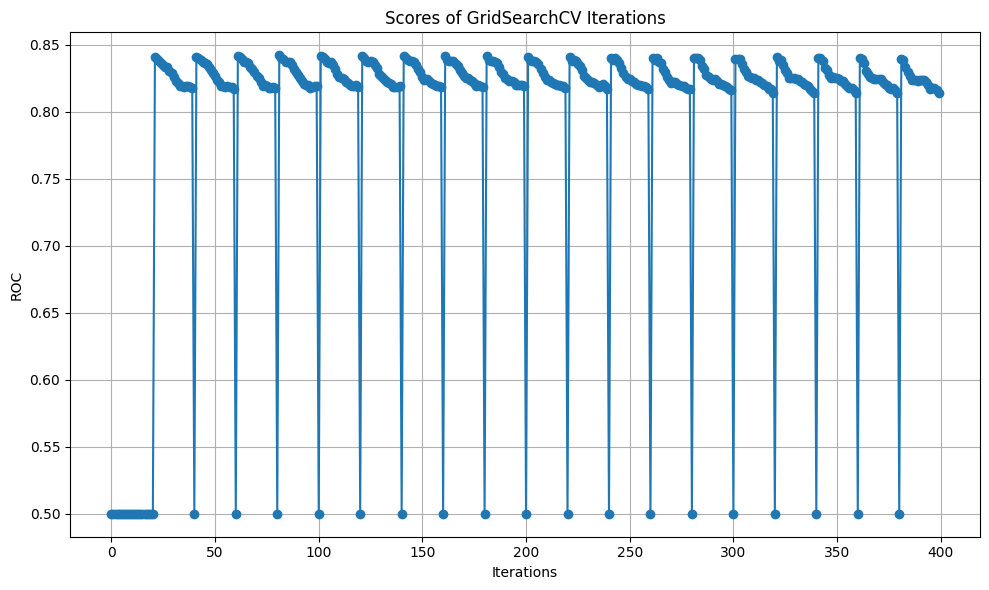

In [270]:
results = search.cv_results_
mean_scores = results['mean_test_score']
params = results['params']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(mean_scores)), mean_scores, marker='o', linestyle='-')
plt.xlabel('Iterations')
plt.ylabel('ROC')
plt.title('Scores of GridSearchCV Iterations')
#plt.xticks(np.arange(len(mean_scores)), [str(param) for param in params], rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [271]:
best_estimator = search.best_estimator_

y_pred = best_estimator.predict(X_test_array)

In [272]:
print(best_estimator)

Pipeline(steps=[('enc', KappaEncoder(kappa=[1, 1, 1, 1, 1, 1, 1, 1])),
                ('clf', KappaClassifier(kappa=4))])


In [273]:
submission = pd.DataFrame({'ID': X_test.index, 'stroke' : y_pred})
submission.to_csv('Submission_Kappa_V47.csv', index=False)